#  Neural Networks 

---

##  Architecture Overview

We define a parametric function
$$
F_\theta:\mathbb{R}^3 \to \mathbb{R}^3
$$
using a neural network with:

- **Input layer**: 3 nodes  
- **Hidden layer 1**: 5 nodes  
- **Hidden layer 2**: 4 nodes  
- **Output layer**: 3 nodes  

Each layer performs:
$$
\text{Layer Output} = \Psi(\alpha + \sum_j \beta_j v_j),
$$
where $\Psi$ is an activation function (e.g., ReLU).

---

##  Layer Equations and Parameter Counting

| Layer | Inputs | Nodes | Parameters per node | Total Parameters |
|:------|:--------|:------|:-------------------|:----------------|
| Hidden 1 | 3 | 5 | $1 + 3 = 4$ | $5 \times 4 = 20$ |
| Hidden 2 | 5 | 4 | $1 + 5 = 6$ | $4 \times 6 = 24$ |
| Output   | 4 | 3 | $1 + 4 = 5$ | $3 \times 4 = 12$ |
| **Total** | — | — | — | **56** |

---

##  Output Layer — Softmax Probabilities

Let the last hidden layer outputs be $v_1,\ldots,v_4$.  
Then each output node $j=0,1,2$ computes:
$$
f_j = e^{\sum_{u=1}^{4}\beta_u^{(j)}v_u},\quad
p_j = \frac{f_j}{\sum_{s=0}^{2} f_s}.
$$

$(p_0,p_1,p_2)$ are class probabilities that sum to 1.

---

## Cross-Entropy Loss and Gradient Descent

Given data $(x^{(i)}, Y^{(i)})$, define
$$
p^{(i)}(\theta)
=\bigl(p^{(i)}_0(\theta), p^{(i)}_1(\theta), p^{(i)}_2(\theta)\bigr)
$$
and
$$
\mathcal{L}(\theta)
=-\frac{1}{N}\sum_{i=1}^{N}\log p^{(i)}_{Y^{(i)}}(\theta).
$$

Gradient descent update:
$$
\theta \leftarrow \theta - \varepsilon \nabla_\theta \mathcal{L}(\theta).
$$

In [1]:
# PyTorch Neural Network: 3-5-4-3 network
import torch, torch.nn as nn, torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

torch.manual_seed(0)

class SimpleNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(3, 5)
        self.layer2 = nn.Linear(5, 4)
        self.output = nn.Linear(4, 3)
        self.activation = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)
    def forward(self, x):
        v1 = self.activation(self.layer1(x))
        v2 = self.activation(self.layer2(v1))
        logits = self.output(v2)
        p = self.softmax(logits)
        return p

model = SimpleNN()
print(model)

# Synthetic data in 3D
N = 300
X = torch.randn(N, 3)
true_W = torch.tensor([[1.0, -0.5, 0.3],
                       [-0.2,  0.8, 0.4],
                       [0.5,   0.2, -0.6]])
logits_true = X @ true_W.T
Y = torch.argmax(logits_true + 0.3*torch.randn_like(logits_true), dim=1)

# Training parameters
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.05)
epochs, batch_size = 100, 32

losses = []
for epoch in range(epochs):
    perm = torch.randperm(N)
    total_loss = 0
    for i in range(0, N, batch_size):
        idx = perm[i:i+batch_size]
        xb, yb = X[idx], Y[idx]
        optimizer.zero_grad()
        p = model(xb)
        loss = criterion(p, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * len(xb)
    losses.append(total_loss / N)
    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1:3d} | Avg. loss = {total_loss/N:.4f}")

SimpleNN(
  (layer1): Linear(in_features=3, out_features=5, bias=True)
  (layer2): Linear(in_features=5, out_features=4, bias=True)
  (output): Linear(in_features=4, out_features=3, bias=True)
  (activation): ReLU()
  (softmax): Softmax(dim=1)
)
Epoch  10 | Avg. loss = 1.0924
Epoch  20 | Avg. loss = 1.0812
Epoch  30 | Avg. loss = 1.0707
Epoch  40 | Avg. loss = 1.0576
Epoch  50 | Avg. loss = 1.0359
Epoch  60 | Avg. loss = 0.9926
Epoch  70 | Avg. loss = 0.9352
Epoch  80 | Avg. loss = 0.8916
Epoch  90 | Avg. loss = 0.8637
Epoch 100 | Avg. loss = 0.8449


##  Visualizing Decision Boundaries (2D Projection)

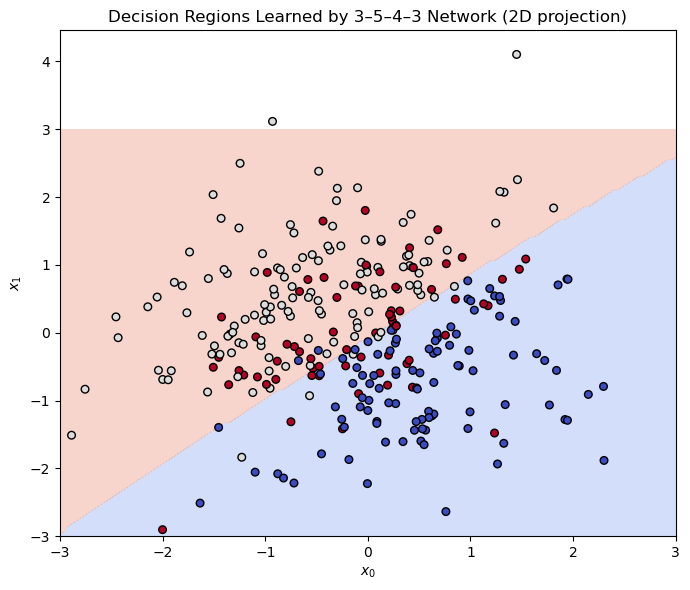

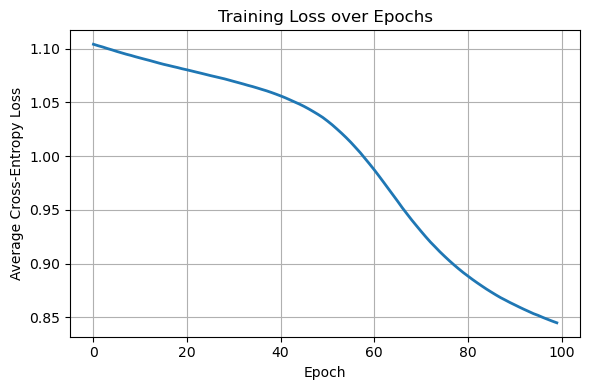

In [2]:
# 2D projection: use x0,x1 features, fix x2 = 0
x0 = torch.linspace(-3, 3, 150)
x1 = torch.linspace(-3, 3, 150)
xx, yy = torch.meshgrid(x0, x1, indexing="xy")
X_grid = torch.stack([xx.flatten(), yy.flatten(), torch.zeros_like(xx.flatten())], dim=1)

with torch.no_grad():
    probs = model(X_grid)
Z = probs.argmax(dim=1).numpy().reshape(xx.shape)

plt.figure(figsize=(7,6))
plt.contourf(xx, yy, Z, levels=2, alpha=0.3, cmap="coolwarm")
plt.scatter(X[:,0], X[:,1], c=Y, cmap="coolwarm", edgecolors='k', s=30)
plt.title("Decision Regions Learned by 3–5–4–3 Network (2D projection)")
plt.xlabel("$x_0$")
plt.ylabel("$x_1$")
plt.tight_layout()
plt.show()

# Plot training loss
plt.figure(figsize=(6,4))
plt.plot(losses, lw=2)
plt.title("Training Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Average Cross-Entropy Loss")
plt.grid(True)
plt.tight_layout()
plt.show()

##  Interpretation of the Visualization

1. **Decision regions**  
   - The contour plot shows how the network partitions $\mathbb{R}^3$ (projected to the $x_0$–$x_1$ plane) into 3 classes.  
   - Nonlinear boundaries arise from repeated transformations  
     $\Psi(\alpha + \sum_j \beta_j v_j)$ in hidden layers.

2. **Training loss**  
   - The decreasing loss curve shows convergence of  
     $$
     \mathcal{L}(\theta)
     = -\frac{1}{N}\sum_i \log p^{(i)}_{Y^{(i)}}(\theta)
     $$
     over epochs.

3. **Softmax outputs**  
   - The network produces probabilities  
     $$
     p_j = \frac{e^{\sum_u \beta_u^{(j)} v_u}}{\sum_s e^{\sum_u \beta_u^{(s)} v_u}}
     $$
     for each class, matching your theoretical description.

4. **Gradient descent**  
   - Each epoch updates parameters $\theta$ according to  
     $$
     \theta \leftarrow \theta - \varepsilon\nabla_\theta\mathcal{L}(\theta).
     $$

---

## Summary

| Concept | Formula / Description |
|----------|-----------------------|
| Node computation | $\Psi(\alpha + \sum_j \beta_j v_j)$ |
| Activation | $\Psi(t) = \max(0, t)$ (ReLU) |
| Output | $p_j = f_j / \sum_s f_s$ |
| Loss | $\mathcal{L}(\theta) = -\frac{1}{N}\sum_i \log p^{(i)}_{Y^{(i)}}(\theta)$ |
| Gradient step | $\theta \leftarrow \theta - \varepsilon\nabla_\theta\mathcal{L}(\theta)$ |
| Training | Mini-batches over multiple epochs |
| Visualization | Nonlinear decision regions in $\mathbb{R}^2$ projection |

## Fiting a Neural Network to Seed Data

We need to find the NN classification rate using:
- Xtrain = training feature data  
    - numpy array rows are obs and columns are features
- Ytrain = vector of coded classes coded 0,1,...,nclasses-1     
- Xtest = test feature data
- Ytest =  vector of coded classes (labels need to be 0,1,...,nclasses-1)
- hidden_layer_sizes = list with numbers of nodes in hidden layers
- batchsize = number of obs in each batch
- nepochs = number of epochs to train on
- lrate = learning rate to use to train


You may wonder why we don't take the batchsize equal to the size of the training dataset. When we process in smaller batches we end up with a noisy gradient, which can have the effect of  avoiding getting stuck at a local minimum of the loss function. This use of "stochastic gradients" is very effective.

There are many decisions to be made - # of layers, # of nodes in each intermediate layer,  learning rate, batchsize. If you try lots of different choices (call these the model options) of these and pick the choice that gives the best performance on the test set, reporting that performance obtained can be very misleading. To remedy this, you should set be breaking up the dataset into 3 pieces:
- a training set
- a test set for deciding which model options lead to the lowest error
- a test set for determining performance of your final choice of model

In [1]:
import os
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch import nn
import numpy as np

def NeuralNetwork(Xtrain,Ytrain,Xtest,Ytest,hidden_layer_sizes,batchsize, nepochs,lrate):
    nobs,nfeatures=Xtrain.shape
    ntest=Xtest.shape[0]
    nclasses=len(set(Ytrain))
    
    #device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    device="cpu"

    # __len__() giving the number of observations in the dataset
    # __getitem__() - enabling one to get a pair/row of X,Y values by using square brackets

    class MyDataSet(Dataset):
        def __init__(self,X,Y):
            self.X=X
            self.Y=Y
            self.N=self.X.shape[0]
            self.K=self.X.shape[1]
        def __len__(self):
            return(self.N)
        def __getitem__(self, idx):
            return self.X[idx],self.Y[idx]

    mydata_train=MyDataSet(Xtrain,Ytrain)
    mydata_test=MyDataSet(Xtest,Ytest)

    class MyNetwork(torch.nn.Module):
        def __init__(self,nfeatures,nclasses, hiddenlayersizes):
            nhiddenlayers=len(hiddenlayersizes)
            super().__init__()
            if nhiddenlayers==0:
                layers=[]
                layers.append(nn.Linear(nfeatures,nclasses))
            else:
                layers=[]
                layers.append(nn.Linear(nfeatures,hiddenlayersizes[0])) # fully connected
                layers.append(nn.Sigmoid()) # activation function 
                for i in range(1,nhiddenlayers):
                    layers.append(nn.Linear(hiddenlayersizes[i-1],hiddenlayersizes[i]))
                    layers.append(nn.Sigmoid()) # activation
                layers.append(nn.Linear(hiddenlayersizes[nhiddenlayers-1],nclasses))
                self.layers=nn.ModuleList(layers)

        def forward(self, x):
            for L in self.layers:
                x=L(x)
            return x

        def probability_vector(self,x):
            for L in self.layers:
                x=L(x)
            x=torch.exp(x)
            s=torch.sum(x)
            x=x/s
            return x

        def output_in_stages(self,x):
            print("input = ")
            print(x)
            print("\n")
            ctr=0
            for L in self.layers:
                x=L(x)
                print("output "+str(ctr))
                print(x)
                print("\n")
                ctr+=1
            x=torch.exp(x)
            s=torch.sum(x)
            x=x/s
            print("output "+str(ctr))
            print(x)
            print("\n")
        

    mynetwork=MyNetwork(nfeatures,nclasses,hidden_layer_sizes)
    mydataloader_train=torch.utils.data.DataLoader(dataset=mydata_train, batch_size=batchsize,shuffle=True)
    mydataloader_test=torch.utils.data.DataLoader(dataset=mydata_test, batch_size=ntest,shuffle=False)
    learning_rate = lrate
    num_epochs =nepochs
    model=mynetwork
    model = model.to(device)
    criterion = torch.nn.CrossEntropyLoss() # ADAM optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        for i,(x,y) in enumerate(mydataloader_train):
            
            x=x.float()
            x=x.to(device)
            y=y.to(device,dtype=torch.long)
            
            optimizer.zero_grad()
            
            outputs=model(x)
            
            loss=criterion(outputs,y)
            loss_value = loss.item()
            
            loss.backward() # compute gradients
            optimizer.step() 
            
        if epoch==10*int(epoch/10):
            print("epoch = {0:5d} loss = {1:8.5f}".format(epoch,loss_value))
    print("epoch = {0:5d} loss = {1:8.5f}".format(epoch,loss_value))
    Confusion=np.zeros(shape=(nclasses,nclasses))
    for i in range(ntest):
        
        d=mydata_test[i]
        x=torch.tensor(d[0])
        ytrue=int(d[1])
        x=torch.reshape(x,(1,nfeatures))
        x=x.to(device).float()
        
        ypred=model(x)
        ypred=model(x).cpu().detach().numpy()[0]

        yp=np.argmax(ypred)
        ytrue=int(d[1])
        
        Confusion[ytrue,yp]+=1
    accuracy=np.sum(np.diag(Confusion))/np.sum(Confusion)
    return(Confusion,accuracy,model)

In [2]:
import pandas as pd
import numpy as np
df=pd.read_csv("seeds_dataset.csv")
df.head()

,Area,Perimeter,Compactness,KernelLen,KernelWidth,AsymmetryCoef,KernelGrooveLen,Class
0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220,1
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956,1
2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825,1
3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805,1
4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175,1


In [3]:
N=df.shape[0]
I=np.random.permutation(range(N))
df=df.loc[I]
df.head()

,Area,Perimeter,Compactness,KernelLen,KernelWidth,AsymmetryCoef,KernelGrooveLen,Class
63,13.22,13.84,0.8680,5.395,3.070,4.157,5.088,1
205,12.19,13.20,0.8783,5.137,2.981,3.631,4.870,3
44,15.11,14.54,0.8986,5.579,3.462,3.128,5.180,1
168,11.35,13.12,0.8291,5.176,2.668,4.337,5.132,3
142,13.34,13.95,0.8620,5.389,3.074,5.995,5.307,3


In [4]:
X=np.array(df)[:,0:7]
Y=np.array(df)[:,7]-1 
Y=Y.astype(int)
print(df.shape)
N=df.shape[0]
Ntrain=int(3*N/4)
Ntest=N-Ntrain
Xtrain=X[0:Ntrain,:]
Ytrain=Y[0:Ntrain]
Xtest=X[Ntrain:N,:]
Ytest=Y[Ntrain:N]

(210, 8)


When we use neural networks it is advisable to normalize the columns so that they are on a common scale. If we don't, then gradients can become unbalanced.
The two most common choices for normalization are 

- converting to z-scores i.e. subtract the sample mean and divide by the sample standard deviation making the sample mean 0 and the sample standard deviation 1.
- linear transformation making the smallest value 0 and the largest value 1 i.e. converting the range from [xmin,xmax] to [0,1].

We should take steps to ensure that whatever transformation we apply to the training data is the same as the one we apply to the test data. (The test data might have a different mean, standard deviation or range). 

sklearn has a function StandardScaler that can learn and apply appropriate transformations of the columns of the training data and to also apply to the test data.

In [5]:
from sklearn.preprocessing import StandardScaler

f=StandardScaler()
XtrainRescaled=f.fit_transform(Xtrain)
XtestRescaled=f.transform(Xtest)

In [6]:
C,acc, model=NeuralNetwork(Xtrain=XtrainRescaled,
              Ytrain=Ytrain,
              Xtest=XtestRescaled,
              Ytest=Ytest,
              hidden_layer_sizes=[10],
              batchsize=25, 
              nepochs=100,
              lrate=.01)

print("accuracy on test set = "+str(acc))
print("confusion matrix = ")
print(C)

epoch =     0 loss =  0.97528
epoch =    10 loss =  0.19594
epoch =    20 loss =  0.31665
epoch =    30 loss =  0.04886
epoch =    40 loss =  0.11619
epoch =    50 loss =  0.17662
epoch =    60 loss =  0.09066
epoch =    70 loss =  0.10999
epoch =    80 loss =  0.01581
epoch =    90 loss =  0.06807
epoch =    99 loss =  0.16528
accuracy on test set = 0.9622641509433962
confusion matrix = 
[[14.  0.  1.]
 [ 0. 19.  0.]
 [ 1.  0. 18.]]


In [7]:
# Print output probabilities and true class for each test feature vector
st="{:^20s}{:5s}  {:5s}".format("output prob", "true", "pred")
print(st)
st="{:^20s}{:5s}  {:5s}".format("vector", "class", "class")
print(st)
for i in range(Xtest.shape[0]):
    x=torch.tensor(XtestRescaled[i,:],dtype=torch.float)
    p=model.probability_vector(x).detach().numpy()
    y=int(Ytest[i])
    ypred=np.argmax(p)
    st="{:5.3f} {:5.3f} {:5.3f}   {:3d}   {:3d}".format(p[0],p[1],p[2],y,ypred)
    print(st)

    output prob     true   pred 
       vector       class  class
0.057 0.942 0.000     1     1
0.002 0.000 0.998     2     2
0.998 0.002 0.001     0     0
0.942 0.014 0.044     0     0
0.025 0.975 0.000     1     1
0.998 0.001 0.001     0     0
0.045 0.955 0.000     1     1
0.023 0.977 0.000     1     1
0.991 0.006 0.003     0     0
0.003 0.000 0.997     2     2
0.850 0.001 0.149     0     0
0.005 0.995 0.000     1     1
0.005 0.004 0.991     2     2
0.006 0.994 0.000     1     1
0.011 0.989 0.000     1     1
0.472 0.517 0.012     1     1
0.056 0.943 0.001     1     1
0.004 0.000 0.995     2     2
0.002 0.000 0.997     2     2
0.010 0.000 0.990     2     2
0.050 0.949 0.001     1     1
0.003 0.000 0.997     2     2
0.006 0.994 0.000     1     1
0.968 0.001 0.032     0     0
0.989 0.008 0.003     0     0
0.004 0.996 0.000     1     1
0.990 0.009 0.001     0     0
0.992 0.004 0.003     0     0
0.874 0.001 0.125     2     0
0.036 0.964 0.000     1     1
0.004 0.000 0.996     2     2
0.00

In [8]:
# check parameters that define the model
model

MyNetwork(
  (layers): ModuleList(
    (0): Linear(in_features=7, out_features=10, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=10, out_features=3, bias=True)
  )
)